In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import splitfolders
import gradio
import math
import shutil
import glob
import keras
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array , load_img

In [2]:
model = Sequential()

model.add(Conv2D(filters= 16 , kernel_size= (3,3), activation= 'relu'))

model.add(Conv2D(filters= 36 , kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 64 , kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 128 , kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate= 0.25))

model.add(Flatten(input_shape = (224,224,3) ))
model.add(Dense(units=64,activation= 'relu'))
model.add(Dropout(rate= 0.25))
model.add(Dense(units= 1, activation= 'sigmoid'))


#model.summary()

In [3]:
model.compile(optimizer='adam', loss= keras.losses.binary_crossentropy, metrics=['accuracy']) 

In [4]:
def preprocessingpretrainedimages(path):
    # input : path 
    # output : pre trained images
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/225, horizontal_flip= True)  #data augmentation
    image = image_data.flow_from_directory(directory= path, target_size= (224,244),batch_size= 64, class_mode= 'binary')

    return image

def preprocessingpretestedimages(path):
    # input : path 
    # output : pre tested images
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/225, horizontal_flip= True) #data augmentation
    image = image_data.flow_from_directory(directory= path, target_size= (224,244),batch_size= 6, class_mode= 'binary')

    return image  

def preProcessingValImages(path):
    # input : path 
    # output : pre tested images
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/225, horizontal_flip= True) #data augmentation
    image = image_data.flow_from_directory(directory= path, target_size= (224,244),batch_size= 6, class_mode= 'binary')

    return image       

In [5]:
train_path = "BrainModelData\Train"
test_path = "BrainModelData\Test"
val_path="BrainModelData\Val"

train_data = preprocessingpretrainedimages(train_path)
test_data = preprocessingpretrainedimages(test_path)
val_data = preProcessingValImages(val_path)

Found 1001 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=6,verbose=1,mode='auto')
mc = ModelCheckpoint(monitor="val_accuracy",filepath="Brain.h5",save_best_only=True,verbose=1,mode='auto') 
cd=[es,mc] 

In [7]:
model_history = model.fit_generator(generator= train_data, steps_per_epoch= 8 , epochs= 30, verbose= 1, validation_data= val_data, validation_steps= 16,callbacks= cd )


C:\Users\hamod\AppData\Local\Temp\ipykernel_808\1525570719.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(generator= train_data, steps_per_epoch= 8 , epochs= 30, verbose= 1, validation_data= val_data, validation_steps= 16,callbacks= cd )


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.5930
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to Brain.h5
8/8 [==============================] - 25s 3s/step - loss: 0.7981 - accuracy: 0.5930 - val_loss: 0.6338 - val_accuracy: 0.6875
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.7285
Epoch 2: val_accuracy did not improve from 0.68750
8/8 [==============================] - 28s 3s/step - loss: 0.5642 - accuracy: 0.7285 - val_loss: 0.6398 - val_accuracy: 0.6354
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7117
Epoch 3: val_accuracy improved from 0.68750 to 0.71875, saving model to Brain.h5
8/8 [==============================] - 26s 3s/step - loss: 0.5597 - accuracy: 0.7117 - val_loss: 0.5744 - val_accuracy: 0.7188
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.7793
Epoch 4: val_accuracy improved from 0.718

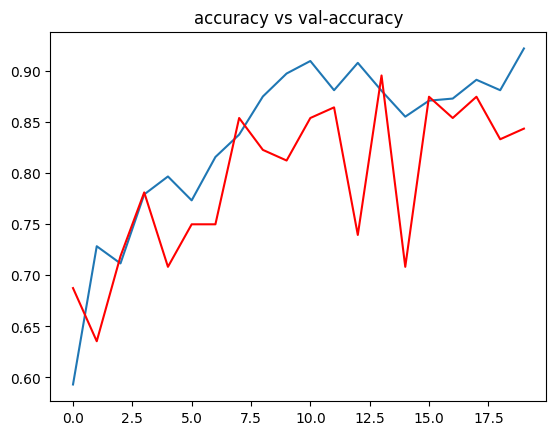

In [8]:
h = model_history.history
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")

plt.title("accuracy vs val-accuracy")
plt.show()

In [9]:
from keras.models import load_model

acc = model.evaluate(val_data)[1]

print(f"the accuracy of our model is { acc * 100 } % ")

17/17 [==============================] - 2s 102ms/step - loss: 0.3758 - accuracy: 0.8235
the accuracy of our model is 82.35294222831726 % 


In [10]:
train_data.class_indices

{'NoTumor': 0, 'Tumor': 1}

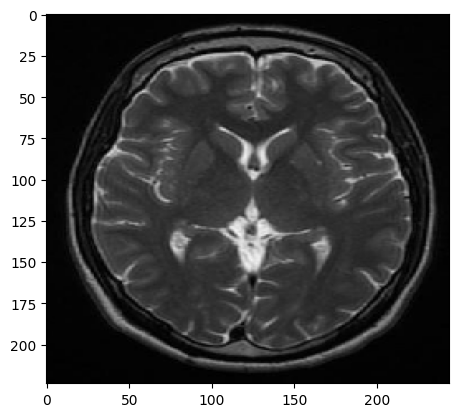

1/1 [==============================] - 0s 113ms/step
image is a brain tumor scan


In [11]:
path = "BrainModelData//Test//NoTumor//no572.jpg"

img = load_img(path , target_size= (224,244))
input_arr = img_to_array(img)/255
input_arr = np.expand_dims(input_arr,axis=0)

plt.imshow(img)
plt.show()

pred = model.predict(input_arr)[0][0]


if pred == 0:
    print(f"image is a brain no tumor scan ")
else:
    print(f"image is a brain tumor scan")  

In [12]:
file_obj = open("labels.txt", "r")
file_data = file_obj.read()

labels = file_data.splitlines()

def classify_image(img):
    # img = tf.reshape((-1,224,224,3))
    # img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    prediction = model.predict(img).flatten()
    confidences = {labels[i]: float(prediction[i]) for i in range(labels.__len__)}
    return confidences


gradio.Interface(fn=classify_image, 
             inputs=gradio.Image(shape=(224, 24)),
             outputs=gradio.Label(num_top_classes=2),
            ).launch(share= True)

Running on local URL:  http://127.0.0.1:7860

Setting up a public link... we have recently upgraded the way public links are generated. If you encounter any problems, please report the issue and downgrade to gradio version 3.13.0
.
Running on public URL: https://a34af9e4-4354-415b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
